In [42]:
import torch 
from torch import nn
from torchsummary import summary

import torchvision as tv
from torchvision import datasets, transforms
from torchvision.transforms.functional import InterpolationMode


import matplotlib.pyplot as plt
import pandas as pd

import os
import time
import datetime
from tqdm.notebook import trange, tqdm
from PIL import Image

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
tv.__version__, torch.__version__

('0.14.1', '1.13.1')

In [3]:
# NVIDIA GEFORCE RTX 2060
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
device

device(type='cuda', index=0)

In [4]:
df = pd.read_csv('./train.csv')
df['image'] = df.image_name.apply(lambda x: f'{x}.jpg')

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df.image, df.target, train_size=0.75, \
                                                      random_state = 8, shuffle = True, stratify= df.target)

# VGG 19

The inference transforms are available at VGG19_BN_Weights.IMAGENET1K_V1.transforms and perform the following preprocessing operations: Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. The images are resized to resize_size=[256] using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224]. Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].

In [6]:
tt_transform = transforms.Compose([#transforms.Resize((256, 256), interpolation=InterpolationMode.BILINEAR), 
                                       transforms.CenterCrop((224, 224)),  
                                       #transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(), 
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) 


image_train = datasets.ImageFolder('C:\\Users\\Blacat\\DL\\Melanoma\\imgs\\small\\train',transform = tt_transform)

In [7]:
image_train

Dataset ImageFolder
    Number of datapoints: 24844
    Root location: C:\Users\Blacat\DL\Melanoma\imgs\small\train
    StandardTransform
Transform: Compose(
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [8]:
image_train.class_to_idx

{'benign': 0, 'malignant': 1}

In [9]:
image_test = datasets.ImageFolder('C:\\Users\\Blacat\\DL\\Melanoma\\imgs\\small\\test', transform = tt_transform )

In [10]:
image_test

Dataset ImageFolder
    Number of datapoints: 8282
    Root location: C:\Users\Blacat\DL\Melanoma\imgs\small\test
    StandardTransform
Transform: Compose(
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [11]:
image_test.class_to_idx

{'benign': 0, 'malignant': 1}

In [12]:
BATCH_SIZE = 16
data_train = torch.utils.data.DataLoader(image_train, batch_size=BATCH_SIZE)
data_test = torch.utils.data.DataLoader(image_test, batch_size=BATCH_SIZE)

In [13]:
# Качество на test
def evaluate_accuracy(data_iter, model):
    
    acc_sum, loss_l_sum, n = 0.0, 0.0, 0
    loss = nn.CrossEntropyLoss(reduction = 'sum')
    
    model.eval()
    for X, y in tqdm(data_iter):
        
        y_prob = model(X.to(device))
        l = loss(y_prob.to(device), y.to(device))
        loss_l_sum += l.item()
        acc_sum += (model(X.to(device)).argmax(axis=1) == y.to(device)).sum().item()
        n += y.to(device).shape[0]
        
    return acc_sum / n, loss_l_sum / n

In [14]:
def train_eval(model, train_iter, test_iter, trainer, num_epochs):
    
    start_time = time.time()
    loss = nn.CrossEntropyLoss(reduction = 'sum')
    loss_train, loss_test = [], []
    
    for epoch in tqdm(range(num_epochs)):
        
        train_l_sum, train_acc_sum, test_acc, n = 0.0, 0.0, 0.0, 0
        
        model.train()
        for X, y in tqdm(train_iter):
            trainer.zero_grad()
            y_prob = model(X.to(device))
            l = loss(y_prob.to(device), y.to(device))
            #print(y_prob, y.to(device))
            l.backward()
            trainer.step()
            
            train_l_sum += l.item()
            train_acc_sum += (y_prob.to(device).argmax(axis=1) == y.to(device)).sum().item()
            n += y.to(device).shape[0]
            
          
        test_acc, loss_test_ev = evaluate_accuracy(test_iter, model)
        
        loss_train.append(train_l_sum/n)
        loss_test.append(loss_test_ev)
        
        print('epoch {:d}, train loss {:.5f}, train acc {:.5f}, test loss {:.5f}, test acc {:.5f}'\
              .format(epoch + 1, train_l_sum / n, train_acc_sum / n, loss_test_ev, test_acc ))
        
    plt.plot(range(0,len(loss_train)), loss_train, label = 'loss due train')
    plt.plot(range(0,len(loss_test)), loss_test, label = 'loss due test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    print('Elapsed time: {:.3f} min'.format((time.time()-start_time)/60))

In [15]:
import torchvision.models as models
from torchvision.models import vgg19#ResNet50_Weights

In [16]:
weights = models.VGG19_Weights.DEFAULT # .DEFAULT = best available weights 
model = vgg19(weights=weights).to(device)

In [17]:
model.parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kern

In [18]:
summary(model=model, input_size = (3, 224, 224), 
        #col_names=["input_size", "output_size", "num_params", "trainable"],
        #col_width=20,
        batch_size = BATCH_SIZE, device = device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 224, 224]           1,792
              ReLU-2         [16, 64, 224, 224]               0
            Conv2d-3         [16, 64, 224, 224]          36,928
              ReLU-4         [16, 64, 224, 224]               0
         MaxPool2d-5         [16, 64, 112, 112]               0
            Conv2d-6        [16, 128, 112, 112]          73,856
              ReLU-7        [16, 128, 112, 112]               0
            Conv2d-8        [16, 128, 112, 112]         147,584
              ReLU-9        [16, 128, 112, 112]               0
        MaxPool2d-10          [16, 128, 56, 56]               0
           Conv2d-11          [16, 256, 56, 56]         295,168
             ReLU-12          [16, 256, 56, 56]               0
           Conv2d-13          [16, 256, 56, 56]         590,080
             ReLU-14          [16, 256,

In [19]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

In [20]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

features.0.weight False
features.0.bias False
features.2.weight False
features.2.bias False
features.5.weight False
features.5.bias False
features.7.weight False
features.7.bias False
features.10.weight False
features.10.bias False
features.12.weight False
features.12.bias False
features.14.weight False
features.14.bias False
features.16.weight False
features.16.bias False
features.19.weight False
features.19.bias False
features.21.weight False
features.21.bias False
features.23.weight False
features.23.bias False
features.25.weight False
features.25.bias False
features.28.weight False
features.28.bias False
features.30.weight False
features.30.bias False
features.32.weight False
features.32.bias False
features.34.weight False
features.34.bias False
classifier.0.weight True
classifier.0.bias True
classifier.3.weight True
classifier.3.bias True
classifier.6.weight True
classifier.6.bias True


In [21]:
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.6, inplace=True), 
    torch.nn.Linear(in_features=25088, out_features=1024, bias=True),
    torch.nn.ReLU(inplace = False),
    torch.nn.Dropout(p=0.4, inplace=False),
    torch.nn.Linear(1024, out_features=2, bias=True), 
    torch.nn.ReLU(inplace = False)).to(device)
                    

In [22]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

features.0.weight False
features.0.bias False
features.2.weight False
features.2.bias False
features.5.weight False
features.5.bias False
features.7.weight False
features.7.bias False
features.10.weight False
features.10.bias False
features.12.weight False
features.12.bias False
features.14.weight False
features.14.bias False
features.16.weight False
features.16.bias False
features.19.weight False
features.19.bias False
features.21.weight False
features.21.bias False
features.23.weight False
features.23.bias False
features.25.weight False
features.25.bias False
features.28.weight False
features.28.bias False
features.30.weight False
features.30.bias False
features.32.weight False
features.32.bias False
features.34.weight False
features.34.bias False
classifier.1.weight True
classifier.1.bias True
classifier.4.weight True
classifier.4.bias True


In [23]:
summary(model=model, input_size = (3, 224, 224), 
        #col_names=["input_size", "output_size", "num_params", "trainable"],
        #col_width=20,
        batch_size = BATCH_SIZE, device = device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 224, 224]           1,792
              ReLU-2         [16, 64, 224, 224]               0
            Conv2d-3         [16, 64, 224, 224]          36,928
              ReLU-4         [16, 64, 224, 224]               0
         MaxPool2d-5         [16, 64, 112, 112]               0
            Conv2d-6        [16, 128, 112, 112]          73,856
              ReLU-7        [16, 128, 112, 112]               0
            Conv2d-8        [16, 128, 112, 112]         147,584
              ReLU-9        [16, 128, 112, 112]               0
        MaxPool2d-10          [16, 128, 56, 56]               0
           Conv2d-11          [16, 256, 56, 56]         295,168
             ReLU-12          [16, 256, 56, 56]               0
           Conv2d-13          [16, 256, 56, 56]         590,080
             ReLU-14          [16, 256,

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1553 [00:00<?, ?it/s]

  0%|          | 0/518 [00:00<?, ?it/s]

epoch 1, train loss 0.69315, train acc 0.98237, test loss 0.69315, test acc 0.98237
Elapsed time: 4.980 min


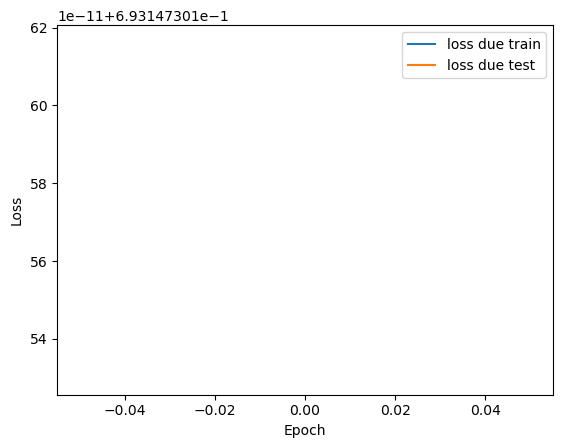

In [26]:
trainer = torch.optim.Adam(model.parameters(), lr=0.001)
train_eval(model, data_train, data_test, trainer, 1)

In [30]:
model.eval().to(device);


In [35]:
sm_kgpath = 'C:\\Users\\Blacat\\DL\\Melanoma\\imgs\\kg_small'

kg_flist = os.listdir(f'{sm_kgpath}')

In [57]:
img_dir = 'C:\\Users\\Blacat\\DL\\Melanoma\\imgs\\kg_small\\ISIC_0052060.jpg'

In [121]:
def get_model_predictions(model,img_path):
    #was_training = model.training
    model.eval()
    img = Image.open(img_path)
    img = tt_transform(img)
    
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        #print(f'outputs: {outputs}')
        torch.softmax(outputs, dim = 1)
        _, preds = torch.max(outputs, 1)

       # model.train(mode=was_training)
        
    return img_path[-16:], preds[0].item()

In [122]:
img_name = []
img_class = []
for img in tqdm(kg_flist):
    i, clss = get_model_predictions(model, f'{sm_kgpath}\\{img}')
    img_name.append(i)
    img_class.append(clss)
    


  0%|          | 0/10982 [00:00<?, ?it/s]

In [123]:
sum(img_class)

0

In [110]:
get_model_predictions(model, img_dir)

outputs: tensor([[0., 0.]], device='cuda:0')


('ISIC_0052060.jpg', tensor([0], device='cuda:0'))

In [102]:
m = nn.Softmax(dim=1)
input = torch.randn(2, 3)
input


tensor([[-0.4001,  1.3059, -1.0103],
        [ 0.2068,  0.8241, -0.8012]])

In [104]:
output = m(input)
output

tensor([[0.1418, 0.7811, 0.0771],
        [0.3107, 0.5760, 0.1134]])

In [107]:
torch.max(output,  1)

torch.return_types.max(
values=tensor([0.7811, 0.5760]),
indices=tensor([1, 1]))